In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import bernoulli
import random
import seaborn as sns
from tqdm import tqdm
import copy
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Задание 3**

Будем моделировать ситуацию

In [2]:
start_age = 25
end_age = 70
age_list = []
income_spouse_list = []
income_list = []
id_list = []
start_id = 1

increment  = 2500

for _ in tqdm(range(20)):
  start_income = 35000
  for age in range(start_age,end_age): 
    id_list.append(start_id)
    # Age
    is_delta = bernoulli(0.7).rvs(size=1)[0]
    size_delta = random.randint(1,7)
    total_age = age + size_delta*is_delta
    age_list.append(total_age)

    # Income spouse
    is_delta = bernoulli(0.7).rvs(size=1)[0]
    size_delta = random.randint(1,10)
    total_income = start_income + increment + is_delta*size_delta*increment
    income_spouse_list.append(total_income)

    # Income 
    is_delta = bernoulli(0.7).rvs(size=1)[0]
    size_delta = random.randint(1,10)
    total_income = total_income + is_delta*size_delta*increment
    income_list.append(total_income)
    
    start_id = start_id + 1 
    start_income = start_income + increment*math.log(age-start_age+1)

100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


In [3]:
data = {'id':id_list, 'age':age_list,'income_spouse':income_spouse_list,'income':income_list}

In [4]:
df = pd.DataFrame(data)

In [5]:
df_train = copy.deepcopy(df.sample(frac=0.5))
df_test = copy.deepcopy(df.loc[~df['id'].isin(df_train['id'])])
print((len(df_train)+len(df_test)) == len(df))

True


In [6]:
df_train.head()

,id,age,income_spouse,income
788,789,49,166516.688919,184016.688919
497,498,28,39232.867951,41732.867951
631,632,28,37500.000000,52500.000000
602,603,42,143762.683625,153762.683625
76,77,56,232730.558883,232730.558883


In [7]:
df_test.head()

,id,age,income_spouse,income
2,3,32,44232.867951,44232.867951
4,5,34,50445.134576,70445.134576
5,6,36,51968.729357,69468.729357
10,11,41,77761.031433,87761.031433
11,12,43,81255.769615,98755.769615


In [8]:
model = smf.ols(formula = 'np.log(income) ~ age + np.log(income_spouse)', data=df_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         np.log(income)   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 1.538e+04
Date:                Sat, 20 Nov 2021   Prob (F-statistic):               0.00
Time:                        11:13:25   Log-Likelihood:                 537.24
No. Observations:                 450   AIC:                            -1068.
Df Residuals:                     447   BIC:                            -1056.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.08

In [9]:
df_train['y_pred'] = model.predict()
df_train['income_pred'] = df_train['y_pred'].apply(lambda x: round(math.exp(x),0))
df_test['y_pred'] = model.predict(df_test[['age','income_spouse']])
df_test['income_pred'] = df_test['y_pred'].apply(lambda x: round(math.exp(x),0))

In [10]:
df_train.head()

,id,age,income_spouse,income,y_pred,income_pred
788,789,49,166516.688919,184016.688919,12.082333,176722.0
497,498,28,39232.867951,41732.867951,10.738394,46092.0
631,632,28,37500.000000,52500.000000,10.697345,44238.0
602,603,42,143762.683625,153762.683625,11.938696,153077.0
76,77,56,232730.558883,232730.558883,12.396670,241994.0


In [11]:
df_test.head()

,id,age,income_spouse,income,y_pred,income_pred
2,3,32,44232.867951,44232.867951,10.853178,51698.0
4,5,34,50445.134576,70445.134576,10.975487,58424.0
5,6,36,51968.729357,69468.729357,11.005418,60199.0
10,11,41,77761.031433,87761.031433,11.378845,87452.0
11,12,43,81255.769615,98755.769615,11.421684,91280.0


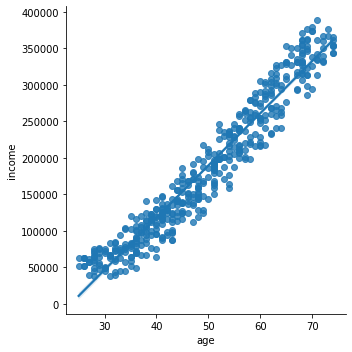

In [12]:
sns.lmplot(x="age", y="income", data=df_test)

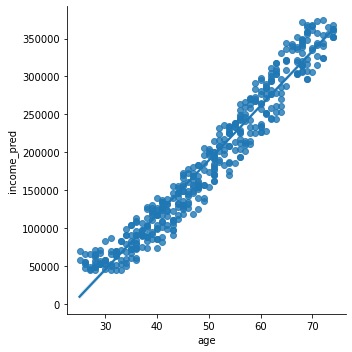

In [13]:
sns.lmplot(x="age", y="income_pred", data=df_test)

In [14]:
print('MSE train: {:.3f}, test: {:.3f}'.format(mean_squared_error(df_train['income'], df_train['income_pred']), 
                                               mean_squared_error(df_test['income'], df_test['income_pred'])))
print('MAE train: {:.3f}, test: {:.3f}'.format(mean_absolute_error(df_train['income'], df_train['income_pred']), 
                                               mean_absolute_error(df_test['income'], df_test['income_pred'])))
print('R^2 train: {:.3f}, test: {:.3f}'.format(r2_score(df_train['income'], df_train['income_pred']), 
                                              r2_score(df_test['income'], df_test['income_pred'])))

MSE train: 75429552.396, test: 76880487.467
MAE train: 7599.570, test: 7713.954
R^2 train: 0.992, test: 0.992


In [15]:
cut_labels_10 = [1,2,3,4,5,6,7,8,9,10]
cut_bins = [35000,76000,112000, 148000, 184000, 220000, 256000,292000,328000,364000,400000]
df_test['income_b'] = pd.cut(df_test['income'], bins=cut_bins, labels=cut_labels_10)
df_test['income_pred_b'] = pd.cut(df_test['income_pred'], bins=cut_bins, labels=cut_labels_10)

In [16]:
df_test.head()

,id,age,income_spouse,income,y_pred,income_pred,income_b,income_pred_b
2,3,32,44232.867951,44232.867951,10.853178,51698.0,1,1
4,5,34,50445.134576,70445.134576,10.975487,58424.0,1,1
5,6,36,51968.729357,69468.729357,11.005418,60199.0,1,1
10,11,41,77761.031433,87761.031433,11.378845,87452.0,2,2
11,12,43,81255.769615,98755.769615,11.421684,91280.0,2,2


In [17]:
df_group_income = df_test.groupby(by=['income_b'],as_index=False)['income'].mean()
df_group_income_pred = df_test.groupby(by=['income_pred_b'],as_index=False)['income_pred'].mean()

In [18]:
df_group = df_group_income.merge(df_group_income_pred, how='left', left_on='income_b', right_on='income_pred_b')
df_group.rename(columns={'income_b':'bin'},inplace=True)
df_group.drop(['income_pred_b'], axis=1, inplace=True)

In [19]:
df_group

,bin,income,income_pred
0,1,60375.909813,59462.333333
1,2,92461.461524,94853.200000
2,3,128656.836944,129380.677966
3,4,165233.886066,164456.510204
4,5,202006.545263,201556.155556
5,6,237253.973583,236914.454545
6,7,271791.819506,272657.675676
7,8,310097.258611,309688.050000
8,9,345217.288822,347048.631579
9,10,373670.846014,368746.222222


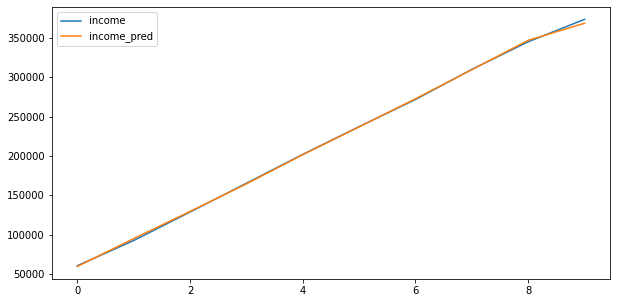

In [20]:
df_group.plot(figsize=(10,5))

### **1. Для соблюдения чистоты эксперимента применялась учебная и тестовая выборка**
### **2. Чтобы минимизировать ошибку прогноза нужно логарифмировать не только прогнозируемый доход, но и доход супруга**
### **3. Логарифмическая функция должна штрафовать большие значения и вытягивать маленькие**
### **4. Возможных причин, почему средние значения прогноза постоянно ниже средних значений факта на всех бакетах, выявить не удалось**